In [ ]:
!pip install mlflow

     |████████████████████████████████| 16.5 MB 199 kB/s 
     |████████████████████████████████| 146 kB 37.4 MB/s 
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 36.2 MB/s 
     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 181 kB 40.3 MB/s 
     |████████████████████████████████| 210 kB 44.2 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=3f2efa83679a6a432bb06ed97bbcc7269294514ac895d8741e56e11b2a6e2ebe
  Stored in directory: /root/.cache/pip/wheels/a2/a1/6d/fa1d22ea25ed8593887437fe1c7e00f6ef307fc240ccd4dc5c
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [ ]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Lambda, BatchNormalization, Rescaling, RandomFlip, Resizing, GlobalAveragePooling2D, Flatten, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_Test.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.1__2527_3.4_(+68.4056309072,+27.9598835551)_FI_Lapland_Pohjois-Lappi_Ivalo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.9__2833_1.7_(+55.6481165684,+160.0826582390)_RU_Kamtsjatka_nan_Atlasovo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.3__2393_0.0_(+66.0312039483,-137.6865802275)_CA_Yukon_nan_Dawson-City.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3863_0.0_(+56.3322734887,-88.1656925490)_CA_Ontario_nan_Greenstone.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3802_0.0_(+58.3646219875,-100.1384386558)_CA_Manitoba_nan_Thompson.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.7__3003_0.0_(+55.7487278802,-72.7721618404)_CA_Quebec_Nord-d

In [ ]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [ ]:
## Leemos las imágenes de train, validacion y test
training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.05,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 64)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.05,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 64)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 64)


Found 10266 files belonging to 29 classes.
Using 9753 files for training.
Found 10266 files belonging to 29 classes.
Using 513 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
print(training.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


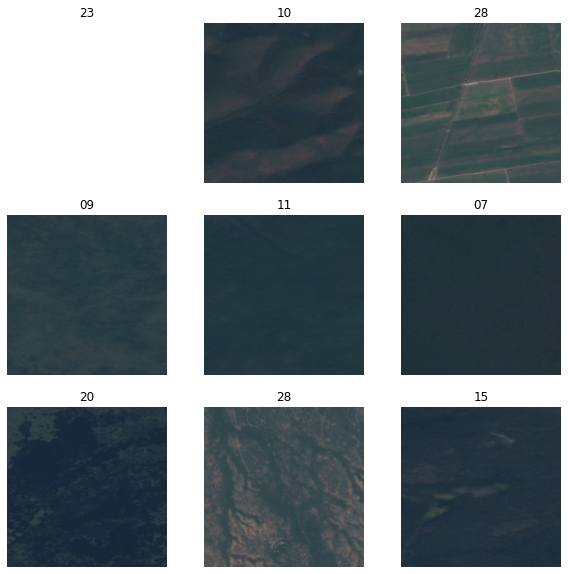

In [ ]:
## Mostramos las 9 primeras imagenes de training
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

def predecir_guardar_test(modelo, nombre_salida, test):

    y_pred = modelo.predict(test)
    classes = np.argmax(y_pred, axis=1)
    classes = np.array(classes)
    classes = classes + 1

    d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
    df = pd.DataFrame(data=d)
    df.to_csv(nombre_salida, index=False)

Epoch 1/60
153/153 [==============================] - 30s 171ms/step - loss: 1.8126 - accuracy: 0.4870 - val_loss: 1.4666 - val_accuracy: 0.5614
Epoch 2/60
153/153 [==============================] - 26s 166ms/step - loss: 1.2020 - accuracy: 0.6357 - val_loss: 1.2598 - val_accuracy: 0.6023
Epoch 3/60
153/153 [==============================] - 26s 165ms/step - loss: 1.0416 - accuracy: 0.6833 - val_loss: 1.2060 - val_accuracy: 0.6160
Epoch 4/60
153/153 [==============================] - 25s 164ms/step - loss: 0.9548 - accuracy: 0.7002 - val_loss: 1.1330 - val_accuracy: 0.6452
Epoch 5/60
153/153 [==============================] - 26s 164ms/step - loss: 0.8937 - accuracy: 0.7170 - val_loss: 1.1242 - val_accuracy: 0.6452
Epoch 6/60
153/153 [==============================] - 26s 164ms/step - loss: 0.8490 - accuracy: 0.7286 - val_loss: 1.1016 - val_accuracy: 0.6374
Epoch 7/60
153/153 [==============================] - 25s 161ms/step - loss: 0.8116 - accuracy: 0.7406 - val_loss: 1.1307 - val_ac

2022/03/30 15:03:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


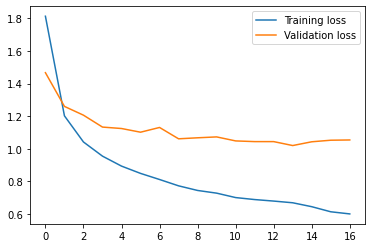

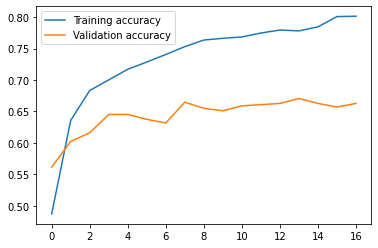

Epoch 1/60
153/153 [==============================] - 85s 509ms/step - loss: 1.6152 - accuracy: 0.5270 - val_loss: 1.1409 - val_accuracy: 0.6472
Epoch 2/60
153/153 [==============================] - 77s 500ms/step - loss: 0.8924 - accuracy: 0.7030 - val_loss: 0.8376 - val_accuracy: 0.7232
Epoch 3/60
153/153 [==============================] - 77s 502ms/step - loss: 0.7094 - accuracy: 0.7581 - val_loss: 0.7053 - val_accuracy: 0.7583
Epoch 4/60
153/153 [==============================] - 77s 500ms/step - loss: 0.6046 - accuracy: 0.7889 - val_loss: 0.6403 - val_accuracy: 0.7856
Epoch 5/60
153/153 [==============================] - 77s 501ms/step - loss: 0.5180 - accuracy: 0.8204 - val_loss: 0.5914 - val_accuracy: 0.8012
Epoch 6/60
153/153 [==============================] - 77s 500ms/step - loss: 0.4569 - accuracy: 0.8403 - val_loss: 0.5699 - val_accuracy: 0.8031
Epoch 7/60
153/153 [==============================] - 77s 501ms/step - loss: 0.4063 - accuracy: 0.8580 - val_loss: 0.5330 - val_ac

2022/03/30 15:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


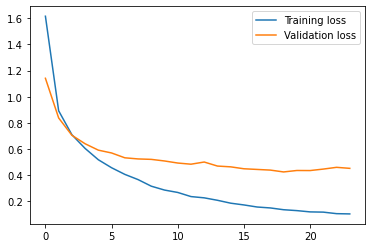

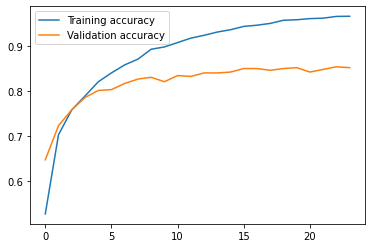

In [ ]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

prediction_layer = Dense(29, activation = "sigmoid")



model = Sequential([
  Lambda(tf.keras.applications.inception_v3.preprocess_input, input_shape=(224, 224, 3)),
  RandomFlip(),
  base_model,
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)


for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

opt = Adam(0.00001)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_fine_tuning_inceptionV3.csv", test)



Epoch 1/60
257/257 [==============================] - 118s 220ms/step - loss: 2.2532 - accuracy: 0.3512 - val_loss: 1.8857 - val_accuracy: 0.4506
Epoch 2/60
257/257 [==============================] - 55s 212ms/step - loss: 1.8431 - accuracy: 0.4455 - val_loss: 1.7303 - val_accuracy: 0.4754
Epoch 3/60
257/257 [==============================] - 55s 212ms/step - loss: 1.7018 - accuracy: 0.4903 - val_loss: 1.7313 - val_accuracy: 0.4910
Epoch 4/60
257/257 [==============================] - 55s 212ms/step - loss: 1.6376 - accuracy: 0.5003 - val_loss: 1.6217 - val_accuracy: 0.5061
Epoch 5/60
257/257 [==============================] - 54s 211ms/step - loss: 1.5844 - accuracy: 0.5212 - val_loss: 1.6585 - val_accuracy: 0.5134
Epoch 6/60
257/257 [==============================] - 55s 214ms/step - loss: 1.4974 - accuracy: 0.5405 - val_loss: 1.6076 - val_accuracy: 0.5183
Epoch 7/60
257/257 [==============================] - 55s 215ms/step - loss: 1.4504 - accuracy: 0.5486 - val_loss: 1.4756 - val_a

2022/03/16 11:20:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


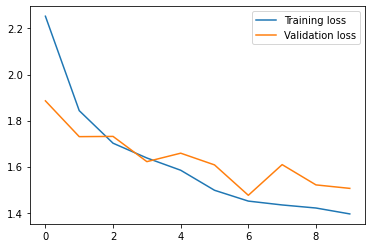

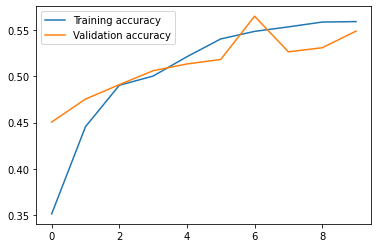

In [ ]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

for layer in base_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  #normalization,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_iniciales_inception_descongelando20_sin_normalizacion.csv", test)



Epoch 1/30
257/257 [==============================] - 63s 223ms/step - loss: 2.8644 - accuracy: 0.1800 - val_loss: 2.4002 - val_accuracy: 0.2650
Epoch 2/30
257/257 [==============================] - 56s 217ms/step - loss: 1.8817 - accuracy: 0.4174 - val_loss: 1.5492 - val_accuracy: 0.5007
Epoch 3/30
257/257 [==============================] - 56s 217ms/step - loss: 1.2796 - accuracy: 0.5785 - val_loss: 1.3703 - val_accuracy: 0.5558
Epoch 4/30
257/257 [==============================] - 56s 217ms/step - loss: 1.0365 - accuracy: 0.6443 - val_loss: 1.2653 - val_accuracy: 0.5835
Epoch 5/30
257/257 [==============================] - 56s 217ms/step - loss: 0.8869 - accuracy: 0.6923 - val_loss: 1.2439 - val_accuracy: 0.5977
Epoch 6/30
257/257 [==============================] - 56s 216ms/step - loss: 0.7505 - accuracy: 0.7342 - val_loss: 1.2745 - val_accuracy: 0.5957
Epoch 7/30
257/257 [==============================] - 56s 216ms/step - loss: 0.6635 - accuracy: 0.7635 - val_loss: 1.2291 - val_ac

2022/03/14 09:52:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


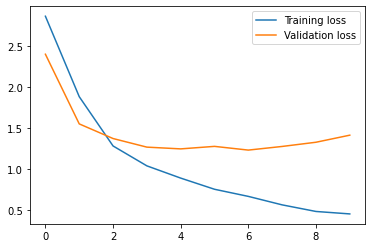

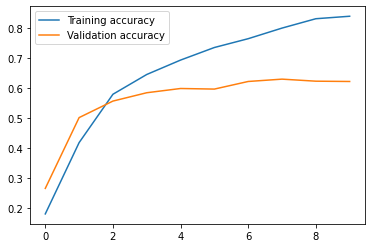

In [ ]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  Dense(1024, activation = "relu"),
  Dense(512, activation = "relu"),
  Dense(32, activation = "relu"),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=30,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "inceptionv3_congelado_dense.csv", test)


In [ ]:
batch_size = 32

train_image_generator = ImageDataGenerator(rotation_range = 15, # en este problema tiene sentido que la imagen pueda ser tomada desde cualquier angulo
                                           zoom_range = 0.3,
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           validation_split = 0.2)


training_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')


validation_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')

total_train = 8236
total_val = 2030


Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.


Epoch 1/40
257/257 [==============================] - 149s 560ms/step - loss: 2.5141 - accuracy: 0.2651 - val_loss: 2.0775 - val_accuracy: 0.3780
Epoch 2/40
257/257 [==============================] - 139s 541ms/step - loss: 1.6531 - accuracy: 0.4712 - val_loss: 1.6933 - val_accuracy: 0.4782
Epoch 3/40
257/257 [==============================] - 141s 547ms/step - loss: 1.4293 - accuracy: 0.5332 - val_loss: 1.7391 - val_accuracy: 0.4678
Epoch 4/40
257/257 [==============================] - 140s 543ms/step - loss: 1.3609 - accuracy: 0.5460 - val_loss: 1.5797 - val_accuracy: 0.4990
Epoch 5/40
257/257 [==============================] - 140s 546ms/step - loss: 1.2651 - accuracy: 0.5870 - val_loss: 1.5066 - val_accuracy: 0.5144
Epoch 6/40
257/257 [==============================] - 139s 542ms/step - loss: 1.2311 - accuracy: 0.5963 - val_loss: 1.5804 - val_accuracy: 0.5074
Epoch 7/40
257/257 [==============================] - 137s 533ms/step - loss: 1.1848 - accuracy: 0.6062 - val_loss: 1.3985 -

2022/03/14 10:24:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


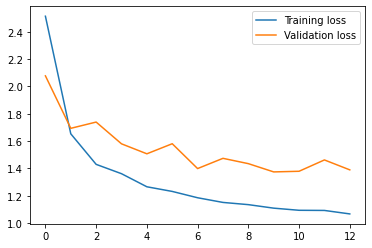

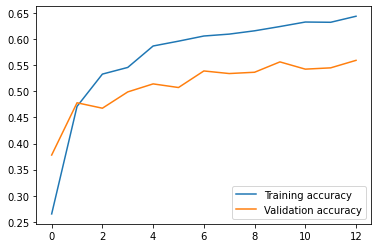

In [ ]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  Dense(1024, activation = "relu"),
  Dense(512, activation = "relu"),
  Dense(32, activation = "relu"),
  prediction_layer
])


opt = Adam()
      
model.compile(loss= SparseCategoricalCrossentropy(from_logits = False), optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_data_augmentation")
mlflow.tensorflow.autolog()

# a partir de TF 2.2, fit ya funciona con generadores, no hace falta usar fit_generator
with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training_generator,
                        epochs=40,
                        steps_per_epoch = total_train // batch_size, # si queremos usar más imágenes, aumentar este parametro y validation_steps
                        validation_data = validation_generator,
                        validation_steps = total_val // batch_size,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "inceptionv3_congelado_data_augmentation.csv", test)
  

Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.
Epoch 1/60
257/257 [==============================] - 124s 481ms/step - loss: 6.5314 - accuracy: 0.0843 - val_loss: 2.6994 - val_accuracy: 0.1443
Epoch 2/60
257/257 [==============================] - 123s 478ms/step - loss: 2.6142 - accuracy: 0.1577 - val_loss: 2.4617 - val_accuracy: 0.1974
Epoch 3/60
257/257 [==============================] - 123s 479ms/step - loss: 2.4278 - accuracy: 0.1990 - val_loss: 2.2750 - val_accuracy: 0.2450
Epoch 4/60
257/257 [==============================] - 123s 479ms/step - loss: 2.2950 - accuracy: 0.2316 - val_loss: 2.5080 - val_accuracy: 0.2267
Epoch 5/60
257/257 [==============================] - 123s 478ms/step - loss: 2.0396 - accuracy: 0.2899 - val_loss: 2.0571 - val_accuracy: 0.2768
Epoch 6/60
257/257 [==============================] - 123s 478ms/step - loss: 1.9152 - accuracy: 0.3306 - val_loss: 2.1407 - val_accuracy: 0.2877
Epoch 7/60
257/257 [==================

2022/03/14 12:24:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


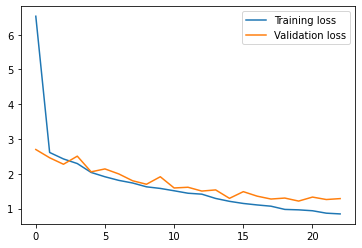

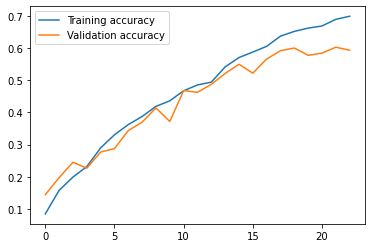

In [ ]:
batch_size = 32

train_image_generator = ImageDataGenerator(rotation_range = 10, # en este problema tiene sentido que la imagen pueda ser tomada desde cualquier angulo
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           rescale = 1/.255,
                                           validation_split = 0.2)


training_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')


validation_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')

total_train = 8236
total_val = 2030


model = Sequential([
  tf.keras.layers.Conv2D(8, 2, activation='relu', input_shape=(224,224,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(100, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(125, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(29, activation = "softmax")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=40,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio_2.csv", test)

In [ ]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = True

prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation)

  mostrarEvolucion(history)
predecir_guardar_test(model, "entrenar_inceptionv3_completo.csv", test)

Epoch 1/60
257/257 [==============================] - 170s 598ms/step - loss: 1.3109 - accuracy: 0.5942 - val_loss: 3.4513 - val_accuracy: 0.3551
Epoch 2/60
257/257 [==============================] - 152s 591ms/step - loss: 0.8125 - accuracy: 0.7172 - val_loss: 2.5460 - val_accuracy: 0.3790
Epoch 3/60
257/257 [==============================] - 152s 590ms/step - loss: 0.6871 - accuracy: 0.7583 - val_loss: 2.0681 - val_accuracy: 0.4944
Epoch 4/60
257/257 [==============================] - 152s 590ms/step - loss: 0.5680 - accuracy: 0.8015 - val_loss: 1.7489 - val_accuracy: 0.5611
Epoch 5/60
257/257 [==============================] - 152s 590ms/step - loss: 0.5116 - accuracy: 0.8183 - val_loss: 3.3881 - val_accuracy: 0.2991
Epoch 6/60
257/257 [==============================] - 152s 590ms/step - loss: 0.4779 - accuracy: 0.8325 - val_loss: 1.3102 - val_accuracy: 0.6113
Epoch 7/60
257/257 [==============================] - 152s 590ms/step - loss: 0.4286 - accuracy: 0.8437 - val_loss: 1.7787 -

87924736/87910968 [==============================] - 2s 0us/step


2022/03/24 08:39:59 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/60
257/257 [==============================] - 76s 228ms/step - loss: 2.4169 - accuracy: 0.2589 - val_loss: 2.6122 - val_accuracy: 0.2460
Epoch 2/60
257/257 [==============================] - 55s 214ms/step - loss: 2.1025 - accuracy: 0.3257 - val_loss: 2.2952 - val_accuracy: 0.2440
Epoch 3/60
257/257 [==============================] - 55s 213ms/step - loss: 1.9768 - accuracy: 0.3644 - val_loss: 2.0998 - val_accuracy: 0.3156
Epoch 4/60
257/257 [==============================] - 55s 212ms/step - loss: 1.9012 - accuracy: 0.3770 - val_loss: 2.1378 - val_accuracy: 0.2947
Epoch 5/60
257/257 [==============================] - 55s 213ms/step - loss: 1.8676 - accuracy: 0.3902 - val_loss: 2.0508 - val_accuracy: 0.3283
Epoch 6/60
257/257 [==============================] - 55s 213ms/step - loss: 1.8185 - accuracy: 0.4033 - val_loss: 1.9093 - val_accuracy: 0.3692
Epoch 7/60
257/257 [==============================] - 55s 214ms/step - loss: 1.8050 - accuracy: 0.4173 - val_loss: 2.0637 - val_ac

2022/03/24 08:51:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


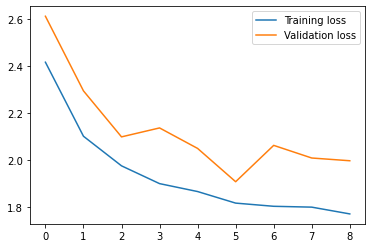

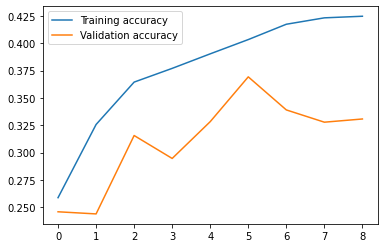

In [ ]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

for layer in base_model.layers[249:]:
    layer.trainable = True

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  RandomFlip(),
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer="rmsprop", 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_incepion_v3_rmsprop.csv", test)



Epoch 1/60
257/257 [==============================] - 66s 224ms/step - loss: 2.3843 - accuracy: 0.2720 - val_loss: 2.3805 - val_accuracy: 0.2518
Epoch 2/60
257/257 [==============================] - 55s 212ms/step - loss: 2.1018 - accuracy: 0.3315 - val_loss: 1.9825 - val_accuracy: 0.3999
Epoch 3/60
257/257 [==============================] - 55s 213ms/step - loss: 1.9958 - accuracy: 0.3611 - val_loss: 1.8676 - val_accuracy: 0.4257
Epoch 4/60
257/257 [==============================] - 55s 212ms/step - loss: 1.9498 - accuracy: 0.3695 - val_loss: 1.8211 - val_accuracy: 0.4501
Epoch 5/60
257/257 [==============================] - 55s 212ms/step - loss: 1.8827 - accuracy: 0.3927 - val_loss: 1.8120 - val_accuracy: 0.4101
Epoch 6/60
257/257 [==============================] - 55s 212ms/step - loss: 1.8605 - accuracy: 0.3973 - val_loss: 1.7364 - val_accuracy: 0.4749
Epoch 7/60
257/257 [==============================] - 54s 211ms/step - loss: 1.8239 - accuracy: 0.4117 - val_loss: 1.7808 - val_ac

2022/03/24 09:15:47 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


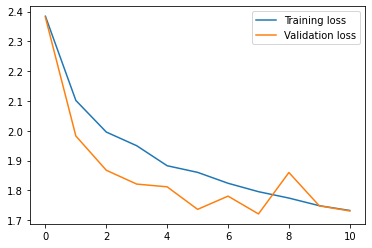

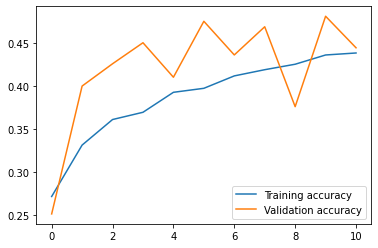

In [ ]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

for layer in base_model.layers[249:]:
    layer.trainable = True

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  RandomFlip(),
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = SGD()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_incepion_v3_sgd.csv", test)



Epoch 1/60
257/257 [==============================] - 63s 218ms/step - loss: 2.3614 - accuracy: 0.2720 - val_loss: 2.2667 - val_accuracy: 0.2776
Epoch 2/60
257/257 [==============================] - 55s 212ms/step - loss: 2.1015 - accuracy: 0.3292 - val_loss: 2.0175 - val_accuracy: 0.3229
Epoch 3/60
257/257 [==============================] - 55s 213ms/step - loss: 1.9876 - accuracy: 0.3499 - val_loss: 2.1057 - val_accuracy: 0.3522
Epoch 4/60
257/257 [==============================] - 55s 212ms/step - loss: 1.9489 - accuracy: 0.3705 - val_loss: 2.0761 - val_accuracy: 0.3293
Epoch 5/60
257/257 [==============================] - 55s 212ms/step - loss: 1.9057 - accuracy: 0.3794 - val_loss: 2.2287 - val_accuracy: 0.2684


2022/03/24 09:22:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


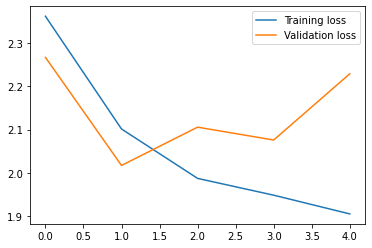

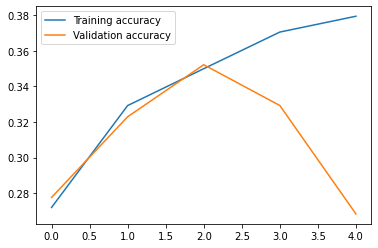

In [ ]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

for layer in base_model.layers[249:]:
    layer.trainable = True

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  RandomFlip(),
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_incepion_v3_adam.csv", test)



# Pruebas con InceptionResNetV2

In [ ]:

base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

for layer in base_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

normalization = Rescaling(1./255)

prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_inceptionResnetv2_descongelando20.csv", test)



KeyboardInterrupt: ignored

# Pruebas TensorFlow Hub

In [ ]:
!pip install --upgrade tensorflow-hub

In [ ]:
import tensorflow_hub as hub

In [ ]:
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", input_shape=(224,224,3))

base_model.trainable = False

# for layer in base_model.layers[-20:]:
#     if not isinstance(layer, BatchNormalization):
#         layer.trainable = True

model = Sequential([
    base_model,
    Dense(29, activation = "softmax")
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_BiT_imagenet_21k_especial_otro_dataset.csv", test)



Epoch 1/60
 79/257 [========>.....................] - ETA: 1:35 - loss: 5.0676 - accuracy: 0.0629

2022/03/24 12:29:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


KeyboardInterrupt: ignored

Epoch 1/60
153/153 [==============================] - 190s 1s/step - loss: 1.1266 - accuracy: 0.6570 - val_loss: 0.7464 - val_accuracy: 0.7563
Epoch 2/60
153/153 [==============================] - 174s 1s/step - loss: 0.6197 - accuracy: 0.7944 - val_loss: 0.6290 - val_accuracy: 0.7875
Epoch 3/60
153/153 [==============================] - 174s 1s/step - loss: 0.5058 - accuracy: 0.8299 - val_loss: 0.5539 - val_accuracy: 0.8187
Epoch 4/60
153/153 [==============================] - 174s 1s/step - loss: 0.4439 - accuracy: 0.8518 - val_loss: 0.5293 - val_accuracy: 0.8265
Epoch 5/60
153/153 [==============================] - 173s 1s/step - loss: 0.3975 - accuracy: 0.8616 - val_loss: 0.5261 - val_accuracy: 0.8363
Epoch 6/60
153/153 [==============================] - 174s 1s/step - loss: 0.3742 - accuracy: 0.8665 - val_loss: 0.4968 - val_accuracy: 0.8304
Epoch 7/60
153/153 [==============================] - 173s 1s/step - loss: 0.3412 - accuracy: 0.8836 - val_loss: 0.5212 - val_accuracy: 0.8148

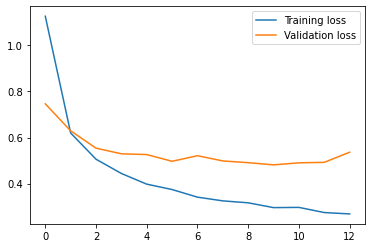

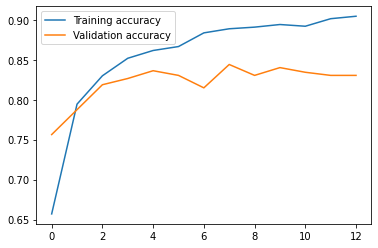

Epoch 1/60
153/153 [==============================] - 432s 3s/step - loss: 2.7207 - accuracy: 0.2002 - val_loss: 8.4170 - val_accuracy: 0.0643


In [ ]:
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", input_shape=(224,224,3))

base_model.trainable = False

model = Sequential([
    RandomFlip(),
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    Dense(29, activation = "sigmoid")
])

      
opt = Adam()

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


callback = EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(training,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callback)
mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_BiT_m-r50x1_data_augmentation_extraccion_caracteristicas.csv", test)

for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True



model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


callback = EarlyStopping(patience=5,restore_best_weights=True)
history = model.fit(training,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callback)
mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_BiT_m-r50x1_data_augmentation_fine_tuning.csv", test)


2022/03/17 11:17:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '408df84bbe114a4aa0e23c37dc32d500', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/60
257/257 [==============================] - 778s 3s/step - loss: 1.0475 - accuracy: 0.7180 - val_loss: 0.6107 - val_accuracy: 0.8237
Epoch 2/60
257/257 [==============================] - 758s 3s/step - loss: 0.4637 - accuracy: 0.8563 - val_loss: 0.5421 - val_accuracy: 0.8359
Epoch 3/60
257/257 [==============================] - 756s 3s/step - loss: 0.4314 - accuracy: 0.8667 - val_loss: 0.5481 - val_accuracy: 0.8373
Epoch 4/60
257/257 [==============================] - 757s 3s/step - loss: 0.4505 - accuracy: 0.8623 - val_loss: 0.5485 - val_accuracy: 0.8378
Epoch 5/60
257/257 [==============================] - 757s 3s/step - loss: 0.4362 - accuracy: 0.8636 - val_loss: 0.5491 - val_accuracy: 0.8383


2022/03/17 12:21:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


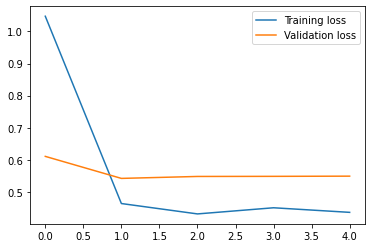

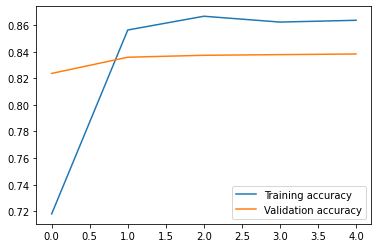

In [ ]:
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x3/1", input_shape=(224,224,3))

base_model.trainable = False

model = Sequential([
    RandomFlip(),
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    Dense(29, activation = "softmax")
])

# optimizer que proponen en BiT: https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html
lr = 0.003
SCHEDULE_BOUNDARIES = [200, 300, 400]
lr_schedule = PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                  values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)

      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=optimizer, 
                  metrics=['accuracy'])

callback = EarlyStopping(patience=3,restore_best_weights=True)
history = model.fit(training,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callback)

mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_BiT_m-r50x3_data_augmentation.csv", test)


Epoch 1/10
257/257 [==============================] - 1234s 5s/step - loss: 0.9625 - accuracy: 0.7346 - val_loss: 0.7147 - val_accuracy: 0.7842
Epoch 2/10
257/257 [==============================] - 1188s 5s/step - loss: 0.5136 - accuracy: 0.8490 - val_loss: 0.6065 - val_accuracy: 0.8169
Epoch 3/10
257/257 [==============================] - 1187s 5s/step - loss: 0.4015 - accuracy: 0.8758 - val_loss: 0.7148 - val_accuracy: 0.8212
Epoch 4/10
257/257 [==============================] - 1187s 5s/step - loss: 0.3511 - accuracy: 0.8972 - val_loss: 0.6893 - val_accuracy: 0.8178
Epoch 5/10
257/257 [==============================] - 1187s 5s/step - loss: 0.3144 - accuracy: 0.9106 - val_loss: 0.7582 - val_accuracy: 0.8334


2022/03/24 11:58:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


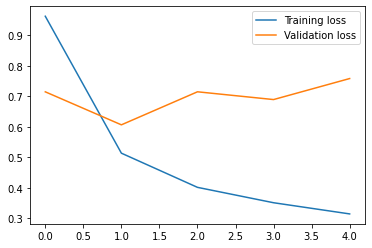

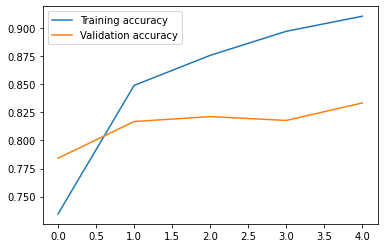

In [ ]:
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x3/1", input_shape=(224,224,3))

base_model.trainable = False

model = Sequential([
    Rescaling(scale=1./127.5, offset=-1.), # escalamos en -1, 1
    RandomFlip(),
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    Dense(29, activation = "softmax")
])

opt = Adam()


model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()



with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=10,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_BiT_imagenet_21k_resnet101x3.csv", test)


In [ ]:
base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x3/1", input_shape=(224,224,3))

base_model.trainable = False

model = Sequential([
    RandomFlip(),
    base_model,
    BatchNormalization(),
    Dropout(0.05),
    Dense(50, activation = "relu"),
    Dense(50, activation = "relu"),
    Dense(29, activation = "sigmoid")
])

opt = Adam()


model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()



with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                        epochs=20,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_BiT_imagenet_21k_resnet101x3.csv", test)


Epoch 1/20
305/305 [==============================] - 1220s 4s/step - loss: 0.8848 - accuracy: 0.7311 - val_loss: 0.4923 - val_accuracy: 0.8207
Epoch 2/20
119/305 [==========>...................] - ETA: 11:23 - loss: 0.4296 - accuracy: 0.8503

# Pruebas Xception

Epoch 1/60
257/257 [==============================] - 108s 402ms/step - loss: 1.9543 - accuracy: 0.4072 - val_loss: 1.6509 - val_accuracy: 0.5129
Epoch 2/60
257/257 [==============================] - 103s 400ms/step - loss: 1.5508 - accuracy: 0.5144 - val_loss: 1.4811 - val_accuracy: 0.5563
Epoch 3/60
257/257 [==============================] - 103s 399ms/step - loss: 1.4289 - accuracy: 0.5422 - val_loss: 1.4174 - val_accuracy: 0.5855
Epoch 4/60
257/257 [==============================] - 103s 400ms/step - loss: 1.3557 - accuracy: 0.5657 - val_loss: 1.3536 - val_accuracy: 0.6011
Epoch 5/60
257/257 [==============================] - 103s 401ms/step - loss: 1.3109 - accuracy: 0.5777 - val_loss: 1.3575 - val_accuracy: 0.6016
Epoch 6/60
257/257 [==============================] - 103s 400ms/step - loss: 1.2739 - accuracy: 0.5899 - val_loss: 1.2801 - val_accuracy: 0.6303
Epoch 7/60
257/257 [==============================] - 103s 400ms/step - loss: 1.2315 - accuracy: 0.6000 - val_loss: 1.2949 -

2022/03/26 16:50:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


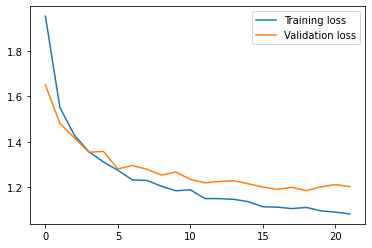

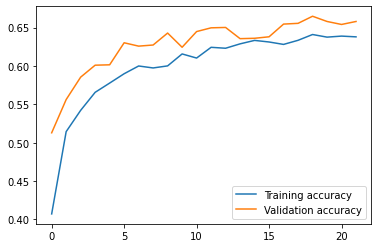

In [ ]:
## Vamos a entrenar usando la red Xception
base_model = tf.keras.applications.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False


prediction_layer = Dense(29, activation = "softmax")


model = Sequential([
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_xception_base.csv", test)



83697664/83683744 [==============================] - 1s 0us/step


2022/03/26 15:30:13 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/60
257/257 [==============================] - 143s 496ms/step - loss: 1.6847 - accuracy: 0.5181 - val_loss: 1.4918 - val_accuracy: 0.6171
Epoch 2/60
257/257 [==============================] - 104s 405ms/step - loss: 1.1048 - accuracy: 0.6497 - val_loss: 1.0903 - val_accuracy: 0.6673
Epoch 3/60
257/257 [==============================] - 105s 406ms/step - loss: 0.9635 - accuracy: 0.6927 - val_loss: 1.0401 - val_accuracy: 0.6771
Epoch 4/60
257/257 [==============================] - 105s 406ms/step - loss: 0.8754 - accuracy: 0.7189 - val_loss: 1.0099 - val_accuracy: 0.6878
Epoch 5/60
257/257 [==============================] - 104s 406ms/step - loss: 0.8158 - accuracy: 0.7314 - val_loss: 0.9681 - val_accuracy: 0.7004
Epoch 6/60
257/257 [==============================] - 104s 405ms/step - loss: 0.7663 - accuracy: 0.7443 - val_loss: 0.9587 - val_accuracy: 0.7048
Epoch 7/60
257/257 [==============================] - 104s 405ms/step - loss: 0.7360 - accuracy: 0.7576 - val_loss: 0.9653 -

2022/03/26 15:55:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


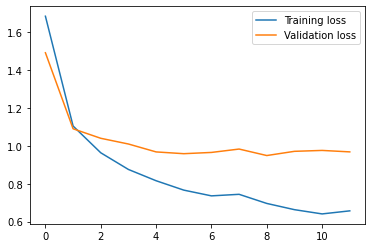

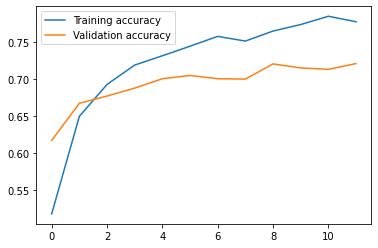

In [ ]:
## Vamos a entrenar usando la red Xception
base_model = tf.keras.applications.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

for layer in base_model.layers[-0:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  Rescaling(scale=1./127.5, offset=-1.), # escalamos en -1, 1, el rango de inceptionv3
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_xception.csv", test)



83697664/83683744 [==============================] - 1s 0us/step


2022/03/27 15:42:21 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/60
257/257 [==============================] - 370s 1s/step - loss: 1.1069 - accuracy: 0.6681 - val_loss: 1.4894 - val_accuracy: 0.5709
Epoch 2/60
257/257 [==============================] - 346s 1s/step - loss: 0.6823 - accuracy: 0.7732 - val_loss: 0.6513 - val_accuracy: 0.7750
Epoch 3/60
257/257 [==============================] - 345s 1s/step - loss: 0.5491 - accuracy: 0.8126 - val_loss: 0.6442 - val_accuracy: 0.7769
Epoch 4/60
257/257 [==============================] - 345s 1s/step - loss: 0.4745 - accuracy: 0.8420 - val_loss: 0.6730 - val_accuracy: 0.7915
Epoch 5/60
257/257 [==============================] - 346s 1s/step - loss: 0.4333 - accuracy: 0.8546 - val_loss: 0.7558 - val_accuracy: 0.7516
Epoch 6/60
257/257 [==============================] - 346s 1s/step - loss: 0.4105 - accuracy: 0.8607 - val_loss: 0.6072 - val_accuracy: 0.7920
Epoch 7/60
257/257 [==============================] - 345s 1s/step - loss: 0.3971 - accuracy: 0.8622 - val_loss: 1.2515 - val_accuracy: 0.6283

2022/03/27 16:37:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


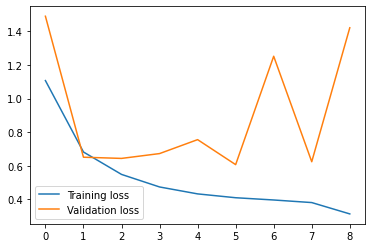

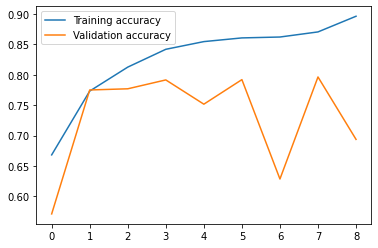

In [ ]:
## Vamos a entrenar usando la red Xception
base_model = tf.keras.applications.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = True

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  Rescaling(scale=1./127.5, offset=-1.), # escalamos en -1, 1, el rango de inceptionv3
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_xception_entrenando_completa.csv", test)



Epoch 1/60
257/257 [==============================] - 352s 1s/step - loss: 1.0030 - accuracy: 0.6770 - val_loss: 1.4327 - val_accuracy: 0.5991
Epoch 2/60
257/257 [==============================] - 345s 1s/step - loss: 0.6071 - accuracy: 0.7881 - val_loss: 1.7045 - val_accuracy: 0.5343
Epoch 3/60
257/257 [==============================] - 345s 1s/step - loss: 0.5032 - accuracy: 0.8254 - val_loss: 1.1404 - val_accuracy: 0.6420
Epoch 4/60
257/257 [==============================] - 345s 1s/step - loss: 0.4485 - accuracy: 0.8398 - val_loss: 0.5911 - val_accuracy: 0.7828
Epoch 5/60
257/257 [==============================] - 345s 1s/step - loss: 0.3770 - accuracy: 0.8669 - val_loss: 0.7315 - val_accuracy: 0.7730
Epoch 6/60
257/257 [==============================] - 344s 1s/step - loss: 0.3596 - accuracy: 0.8719 - val_loss: 0.9066 - val_accuracy: 0.7170
Epoch 7/60
257/257 [==============================] - 345s 1s/step - loss: 0.3322 - accuracy: 0.8857 - val_loss: 0.6719 - val_accuracy: 0.7584

2022/03/27 17:28:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


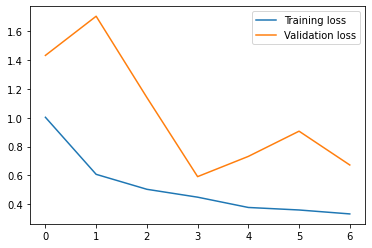

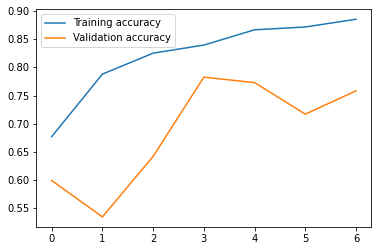

In [ ]:
## Vamos a entrenar usando la red Xception
base_model = tf.keras.applications.Xception(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = True

prediction_layer = Dense(29, activation = "sigmoid")



model = Sequential([
  RandomFlip(),
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "resultados_xception_entrenando_completa_sigmoid.csv", test)



83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/60
305/305 [==============================] - 114s 355ms/step - loss: 1.5568 - accuracy: 0.5469 - val_loss: 1.3585 - val_accuracy: 0.6316
Epoch 2/60
305/305 [==============================] - 106s 345ms/step - loss: 1.0552 - accuracy: 0.6643 - val_loss: 1.0808 - val_accuracy: 0.6628
Epoch 3/60
305/305 [==============================] - 106s 346ms/step - loss: 0.9196 - accuracy: 0.7052 - val_loss: 1.0803 - val_accuracy: 0.6647
Epoch 4/60
305/305 [==============================] - 106s 346ms/step - loss: 0.8317 - accuracy: 0.7305 - val_loss: 1.0496 - val_accuracy: 0.6862
Epoch 5/60
305/305 [==============================] - 105s 345ms/step - loss: 0.7756 - accuracy: 0.7390 - val_loss: 1.0123 - val_accuracy: 0.7018
Epoch 6/60
305/305 [==============================] - 105s 345ms/step - loss: 0.7240 - accuracy: 0.7585 - val_loss: 1.0520 - val_accuracy: 0.6823
Epoch 7/60
305/305 [==============================] - 105s 

2022/03/28 17:35:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


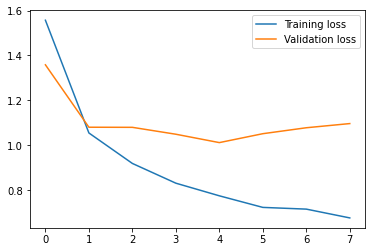

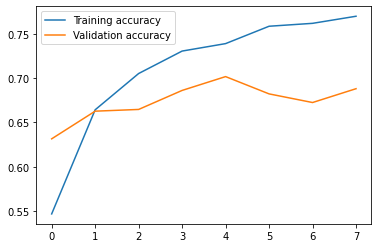

Epoch 1/60
305/305 [==============================] - 430s 1s/step - loss: 0.9356 - accuracy: 0.7205 - val_loss: 0.5986 - val_accuracy: 0.7992
Epoch 2/60
305/305 [==============================] - 420s 1s/step - loss: 0.4658 - accuracy: 0.8443 - val_loss: 0.4654 - val_accuracy: 0.8499
Epoch 3/60
305/305 [==============================] - 420s 1s/step - loss: 0.3397 - accuracy: 0.8793 - val_loss: 0.4196 - val_accuracy: 0.8460
Epoch 4/60
305/305 [==============================] - 420s 1s/step - loss: 0.2703 - accuracy: 0.9064 - val_loss: 0.4318 - val_accuracy: 0.8752
Epoch 5/60
305/305 [==============================] - 421s 1s/step - loss: 0.2298 - accuracy: 0.9175 - val_loss: 0.3507 - val_accuracy: 0.8811
Epoch 6/60
305/305 [==============================] - 422s 1s/step - loss: 0.2104 - accuracy: 0.9252 - val_loss: 0.3673 - val_accuracy: 0.8674
Epoch 7/60
305/305 [==============================] - 421s 1s/step - loss: 0.1773 - accuracy: 0.9368 - val_loss: 0.4159 - val_accuracy: 0.8694

2022/03/28 18:33:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


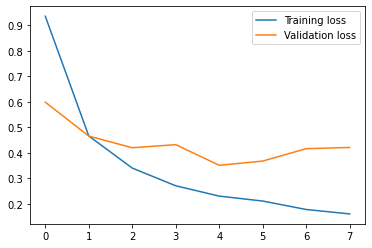

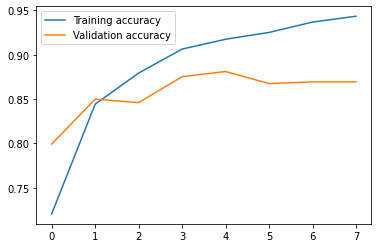

In [ ]:

## Vamos a entrenar usando la red xception
base_model = tf.keras.applications.Xception(include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

prediction_layer = Dense(29, activation = "softmax")



model = Sequential([
  Lambda(tf.keras.applications.xception.preprocess_input, input_shape=(224, 224, 3)),
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.15),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

opt = Adam(0.0001)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_fine_tuning_xception.csv", test)



Epoch 1/60
305/305 [==============================] - 110s 348ms/step - loss: 1.7643 - accuracy: 0.5543 - val_loss: 1.2307 - val_accuracy: 0.5984
Epoch 2/60
305/305 [==============================] - 105s 344ms/step - loss: 1.0731 - accuracy: 0.6800 - val_loss: 1.1725 - val_accuracy: 0.6530
Epoch 3/60
305/305 [==============================] - 105s 344ms/step - loss: 0.8771 - accuracy: 0.7175 - val_loss: 1.1166 - val_accuracy: 0.6784
Epoch 4/60
305/305 [==============================] - 105s 344ms/step - loss: 0.7606 - accuracy: 0.7438 - val_loss: 1.1466 - val_accuracy: 0.6823
Epoch 5/60
305/305 [==============================] - 105s 345ms/step - loss: 0.7311 - accuracy: 0.7614 - val_loss: 1.0262 - val_accuracy: 0.7018
Epoch 6/60
305/305 [==============================] - 105s 344ms/step - loss: 0.6459 - accuracy: 0.7826 - val_loss: 1.0481 - val_accuracy: 0.6940
Epoch 7/60
305/305 [==============================] - 105s 344ms/step - loss: 0.6159 - accuracy: 0.7898 - val_loss: 1.0965 -

2022/03/28 19:00:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


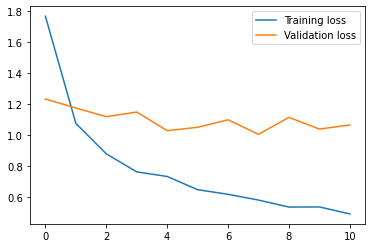

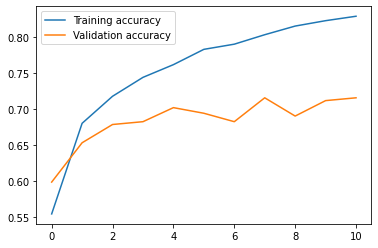

Epoch 1/60
305/305 [==============================] - 425s 1s/step - loss: 0.9686 - accuracy: 0.7183 - val_loss: 0.6196 - val_accuracy: 0.8168
Epoch 2/60
305/305 [==============================] - 426s 1s/step - loss: 0.4918 - accuracy: 0.8352 - val_loss: 0.4484 - val_accuracy: 0.8499
Epoch 3/60
305/305 [==============================] - 425s 1s/step - loss: 0.3549 - accuracy: 0.8749 - val_loss: 0.3771 - val_accuracy: 0.8830
Epoch 4/60
305/305 [==============================] - 424s 1s/step - loss: 0.2844 - accuracy: 0.8995 - val_loss: 0.3594 - val_accuracy: 0.8791
Epoch 5/60
305/305 [==============================] - 424s 1s/step - loss: 0.2467 - accuracy: 0.9094 - val_loss: 0.3956 - val_accuracy: 0.8811
Epoch 6/60
305/305 [==============================] - 425s 1s/step - loss: 0.2137 - accuracy: 0.9229 - val_loss: 0.3503 - val_accuracy: 0.8811
Epoch 7/60
305/305 [==============================] - 425s 1s/step - loss: 0.1814 - accuracy: 0.9345 - val_loss: 0.3494 - val_accuracy: 0.8791

2022/03/28 20:13:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


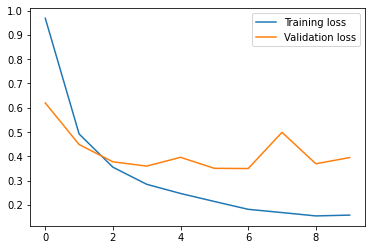

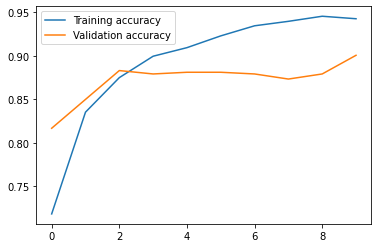

In [ ]:

## Vamos a entrenar usando la red xception
base_model = tf.keras.applications.Xception(include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

prediction_layer = Dense(29, activation = "sigmoid")



model = Sequential([
  Lambda(tf.keras.applications.xception.preprocess_input, input_shape=(224, 224, 3)),
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  Dense(1024, activation = "relu"),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

opt = Adam(0.0001)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_fine_tuning_xception.csv", test)



83697664/83683744 [==============================] - 1s 0us/step


2022/03/30 17:37:32 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/60
153/153 [==============================] - 116s 653ms/step - loss: 2.9221 - accuracy: 0.5611 - val_loss: 2.0523 - val_accuracy: 0.5809
Epoch 2/60
153/153 [==============================] - 97s 631ms/step - loss: 1.8404 - accuracy: 0.6871 - val_loss: 1.7096 - val_accuracy: 0.6686
Epoch 3/60
153/153 [==============================] - 97s 630ms/step - loss: 1.5325 - accuracy: 0.7257 - val_loss: 1.7162 - val_accuracy: 0.6628
Epoch 4/60
153/153 [==============================] - 97s 629ms/step - loss: 1.4160 - accuracy: 0.7370 - val_loss: 1.8162 - val_accuracy: 0.6511
Epoch 5/60
153/153 [==============================] - 97s 631ms/step - loss: 1.3552 - accuracy: 0.7528 - val_loss: 1.7600 - val_accuracy: 0.6998


2022/03/30 17:47:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


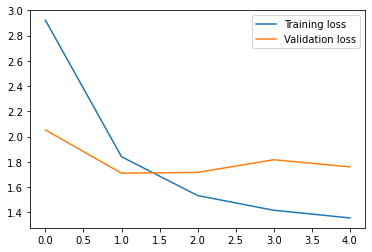

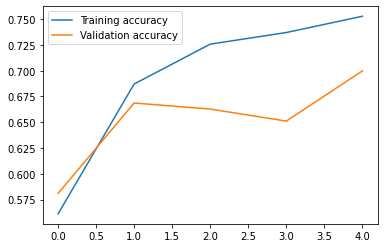

Epoch 1/60
153/153 [==============================] - 404s 3s/step - loss: 1.6069 - accuracy: 0.7271 - val_loss: 1.6550 - val_accuracy: 0.7368
Epoch 2/60
153/153 [==============================] - 392s 3s/step - loss: 1.0197 - accuracy: 0.8594 - val_loss: 1.1494 - val_accuracy: 0.8421
Epoch 3/60
153/153 [==============================] - 392s 3s/step - loss: 0.8718 - accuracy: 0.8992 - val_loss: 0.9546 - val_accuracy: 0.8830
Epoch 4/60
153/153 [==============================] - 390s 3s/step - loss: 0.8345 - accuracy: 0.9179 - val_loss: 1.0333 - val_accuracy: 0.8577
Epoch 5/60
153/153 [==============================] - 390s 3s/step - loss: 0.7619 - accuracy: 0.9351 - val_loss: 0.9908 - val_accuracy: 0.8596
Epoch 6/60
153/153 [==============================] - 389s 3s/step - loss: 0.7472 - accuracy: 0.9368 - val_loss: 0.9492 - val_accuracy: 0.8908
Epoch 7/60
153/153 [==============================] - 389s 3s/step - loss: 0.7131 - accuracy: 0.9500 - val_loss: 0.9071 - val_accuracy: 0.8791

2022/03/30 21:15:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


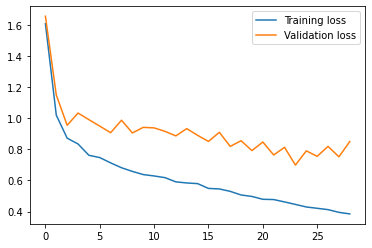

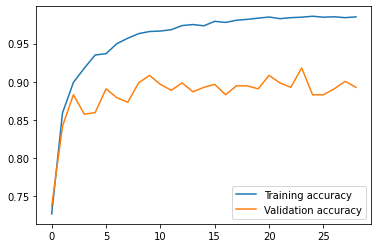

In [ ]:

## Vamos a entrenar usando la red xception
base_model = tf.keras.applications.Xception(include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

prediction_layer = Dense(29, activation = "sigmoid")



model = Sequential([
  Lambda(tf.keras.applications.xception.preprocess_input, input_shape=(224, 224, 3)),
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dense(1024, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

opt = Adam(0.0001)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_fine_tuning_xception.csv", test)



83697664/83683744 [==============================] - 1s 0us/step


2022/03/31 09:05:15 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/60
153/153 [==============================] - 123s 664ms/step - loss: 1.6590 - accuracy: 0.5711 - val_loss: 1.8726 - val_accuracy: 0.6160
Epoch 2/60
153/153 [==============================] - 99s 642ms/step - loss: 1.1615 - accuracy: 0.6920 - val_loss: 1.3564 - val_accuracy: 0.6686
Epoch 3/60
153/153 [==============================] - 99s 641ms/step - loss: 1.0411 - accuracy: 0.7217 - val_loss: 1.2035 - val_accuracy: 0.6862
Epoch 4/60
153/153 [==============================] - 99s 641ms/step - loss: 0.9756 - accuracy: 0.7392 - val_loss: 1.1866 - val_accuracy: 0.6920
Epoch 5/60
153/153 [==============================] - 98s 640ms/step - loss: 0.9421 - accuracy: 0.7527 - val_loss: 1.2039 - val_accuracy: 0.7018
Epoch 6/60
153/153 [==============================] - 99s 642ms/step - loss: 0.8941 - accuracy: 0.7674 - val_loss: 1.1389 - val_accuracy: 0.7329
Epoch 7/60
153/153 [==============================] - 98s 636ms/step - loss: 0.8734 - accuracy: 0.7710 - val_loss: 1.1747 - val_a

2022/03/31 09:25:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


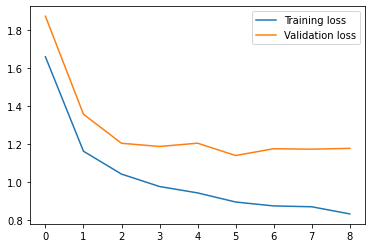

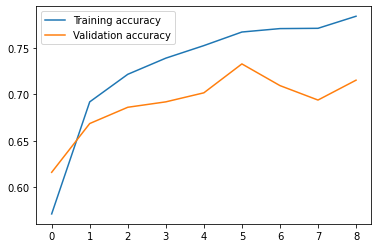

Epoch 1/60
153/153 [==============================] - 411s 3s/step - loss: 0.9870 - accuracy: 0.7441 - val_loss: 1.0249 - val_accuracy: 0.7427
Epoch 2/60
153/153 [==============================] - 398s 3s/step - loss: 0.5588 - accuracy: 0.8690 - val_loss: 0.5960 - val_accuracy: 0.8596
Epoch 3/60
153/153 [==============================] - 398s 3s/step - loss: 0.4450 - accuracy: 0.9096 - val_loss: 0.5313 - val_accuracy: 0.8558
Epoch 4/60
153/153 [==============================] - 398s 3s/step - loss: 0.3898 - accuracy: 0.9296 - val_loss: 0.5003 - val_accuracy: 0.8772
Epoch 5/60
153/153 [==============================] - 398s 3s/step - loss: 0.3469 - accuracy: 0.9469 - val_loss: 0.4550 - val_accuracy: 0.8967
Epoch 6/60
153/153 [==============================] - 397s 3s/step - loss: 0.3252 - accuracy: 0.9511 - val_loss: 0.4386 - val_accuracy: 0.9103
Epoch 7/60
153/153 [==============================] - 397s 3s/step - loss: 0.3007 - accuracy: 0.9586 - val_loss: 0.4749 - val_accuracy: 0.8928

2022/03/31 11:13:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


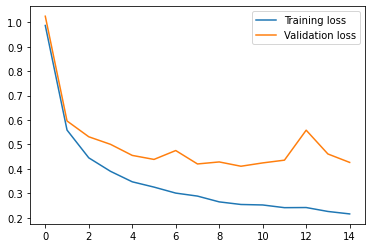

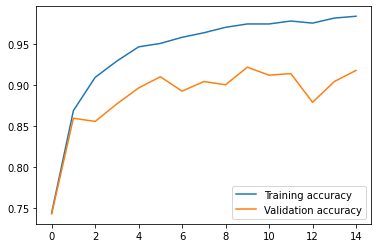

In [ ]:

## Vamos a entrenar usando la red xception
base_model = tf.keras.applications.Xception(include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

prediction_layer = Dense(29, activation = "sigmoid")



model = Sequential([
  Lambda(tf.keras.applications.xception.preprocess_input, input_shape=(224, 224, 3)),
  RandomFlip(),
  base_model,
  BatchNormalization(),
  Dropout(0.15),
  Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  BatchNormalization(),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

opt = Adam(0.0001)

model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                        epochs=60,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)


predecir_guardar_test(model, "resultados_fine_tuning_xception_dropout.csv", test)



# Pruebas redes propias

In [ ]:
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(128, 3, activation='elu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='elu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='elu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='elu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='elu'),
    tf.keras.layers.Dense(1024, activation='elu'),
    tf.keras.layers.Dense(1024, activation='elu'),
    tf.keras.layers.Dense(29, activation = "sigmoid")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=40,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio.csv", test)

2022/03/31 09:05:08 INFO mlflow.tracking.fluent: Experiment with name 'Prueba_entrenamiento_todo_dense' does not exist. Creating a new experiment.
2022/03/31 09:05:09 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


KeyboardInterrupt: ignored